# Naive Optimization Attempt
No extra stuff, just optimizing over the latent space to see what happens.<br>
Expectation - we get X-rays with non-meaningful perturbations

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# allow helper import
import sys
sys.path.append('../assets/scripts')

from helper import *
import torch.nn as nn
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from cheff import CheffAEModel
from torchvision.transforms.functional import to_pil_image, to_tensor
import torchvision.transforms as transforms

In [2]:
# init autoencoder
device = 'cpu'
sdm_path = '../assets/models/cheff_diff_uncond.pt'
ae_path = '../assets/models/cheff_autoencoder.pt'
cheff_ae = CheffAEModel(model_path=ae_path, device=device)

# init cxr-age
cxr_age = load_model()

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

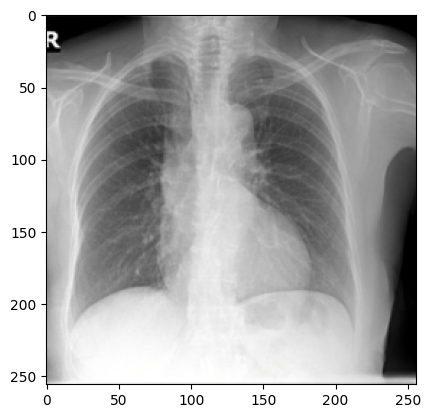

In [4]:
# load, plot image
img_path = '../assets/cxrs/sample1.png'
img = Image.open(img_path)
plt.imshow(img)

# get latent space representation
img = to_tensor(img.convert('RGB')).unsqueeze(0).to(device)
latent_rep = cheff_ae.encode(img)

In [10]:
latent_rep1 = nn.Parameter(latent_rep.clone())
opt = torch.optim.Adam([latent_rep1], lr=0.01)

opt.zero_grad()

img_orig = cheff_ae.decode(latent_rep1)

: 

In [5]:
latent_rep1 = nn.Parameter(latent_rep.clone())
opt = torch.optim.AdamW([latent_rep1], lr=0.2)
epochs = 10
incentive = 'high'

for i in range(epochs):
    opt.zero_grad()

    # decode latent space rep
    img_orig = cheff_ae.decode(latent_rep1)
    print(img_orig.requires_grad)
    # ^^ this asshole is detaching the computation graph

    # pass img through cxrage model
    img = transform(img_orig)
    pred = cxr_age.model(img)
    loss = -pred if incentive == 'high' else pred # very naive, probably worth improving

    # optimize latent rep
    loss.backward()
    opt.step()

    # plot optimized image with age prediction and epoch
    plt.figure()
    plt.imshow(to_pil_image(img_orig[0].cpu()))
    plt.title(f'{i}, {out_to_age(pred).item()}')
    plt.axis('off')
    plt.show()

: 